In [18]:
import random
import time

import numpy as np 
import torch
from scipy import integrate
import pandas as pd
import pickle as pkl

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation



In [19]:
def runge_katta_4(self, f, tn, yn, h):
    k1 = f(tn, yn)
    k2 = f(tn + h/2, yn + h * (k1/2))
    k3 = f(tn + h/2, yn + h * (k2/2))
    k4 = f(tn + h  , yn + h * k3)
    return tn + h, yn + (1/6) * h * (k1 + 2*k2 + 2*k3 + k4)

def get_h_k(new_k, U_shape):
    U_bounds = [[0, U_bound] for U_bound in U_shape]
    integrand = lambda *x : np.prod(np.cos(np.array(x)*np.array(new_k))**2)
    integral_result, _ = integrate.nquad(integrand, U_bounds)
    return np.sqrt(integral_result)

def get_fourier_fn_k(new_k, U_shape):
    # only torch one because we need gradient
    h_k = torch.tensor(get_h_k(new_k, U_shape))
    return lambda x : (1/h_k) * torch.prod(torch.cos(x*new_k))

def get_lambda_k(new_k, n):
    s = (n+1)/2
    lambda_k = 1 / (1 + np.linalg.norm(new_k)**2)**s
    return lambda_k

def get_mu_k(mu_dist, f_k, U_shape):
    U_bounds = [[0, U_bound] for U_bound in U_shape]
    # is mu defined everywhere in the bounds
    integrand = lambda *x: mu_dist(np.array(x)) * f_k(torch.tensor(x)).numpy()
    integral_result, _ = integrate.nquad(integrand, U_bounds)
    return integral_result

def get_grad_fourier_fn_k(fourier_k):
    return lambda x: torch.autograd.functional.jacobian(fourier_k, x)
    
def get_functions_k(k, mu_dist, U_shape, N):
    n = len(U_shape)
    new_k = torch.tensor(k)*np.pi/torch.tensor(U_shape)
    fourier_k = get_fourier_fn_k(new_k, U_shape)
    grad_fourier_k = get_grad_fourier_fn_k(fourier_k)
    lambda_k = get_lambda_k(new_k, n)
    mu_k = get_mu_k(mu_dist, fourier_k, U_shape)
    return {'fourier_k': fourier_k, 
            'grad_fourier_k': grad_fourier_k, 
            'mu_k': mu_k, 
            'C_k': torch.zeros(N, 1),
            'lambda_k': lambda_k}

def get_functions(U_shape, mu_dist, K, N):
    n = len(U_shape)
    return {k: get_functions_k(k, mu_dist, U_shape, N) for k in np.ndindex(*[K]*n)}





In [42]:
class Agent:
    def __init__(self, index, N, position, U_shape, umax, k_bands, eps=1e-5):
        """
        index : number identifier, used in adjacency matrix
        position : initial position, dim n
        U_shape : movement space
        N : number of agents
        umax : max control
        k_bands : the bands it listens to
        eps : boundary distances
        """
        self.index = index # identifier
        self.x_log = [position] # position log
        self.u_log = [] # control log
        self.U_shape = U_shape
        self.n = len(U_shape)
        self.totalNum = N   # total number of agents
        self.N = N
        e_init = 0
        for k in k_bands:
            e_init += lambd[k]*(fourier[k](position)-mu[k])**2
        self.e_log = [e_init] # ergodicity log

        self.umax = umax 
        self.k_bands = k_bands
        self.eps = eps

        self.c_k = {k : fourier[k](position) for k in k_bands} # shared
        self.agent_c_k = {k : fourier[k](position) for k in k_bands} # used for calculating overall ergodicity
        # when communicating, just update the old c_k with the shared value
        # NOT averaged

    def update_shared_c_k(self, new_values):
        self.c_k = new_values
        # self.agent_c_k = self.c_k # not sure

    def update_adj_neighbors(self, new_value):
        self.N = new_value

    def apply_dynamics(self, t, delta_t):
        """ Prior to apply_dynamics is communication step  -- updates c_k and Neighbors """
        """ Move """
        B = torch.zeros(self.n) 
        for k in self.k_bands: # np.ndindex(*[K]*n):
            S_k = self.totalNum*t*(self.c_k[k] - mu[k])
            grad_f_k = grad_fourier[k]
            B += lambd[k]*S_k*grad_f_k(self.x_log[-1])   

        if (torch.norm(B) < self.eps 
            or (self.x_log[-1] < self.eps).any() 
            or (torch.tensor(self.U_shape) - self.x_log[-1] < self.eps).any()):
            print("Agent: ", self.index, " had oh no at time ", t)
            
            U_center = torch.tensor(self.U_shape)*0.5
            if (U_center == self.x_log[-1]).all():
                # move in random direction away from center 
                assert(self.x_log[-1].size == self.n)
                B = torch.zeros(self.n)
                r_idx = 0
                # r_idx = random.randrange(self.n)
                B[r_idx] = 1
                
            else:
                # aim towards center if not already at center
                B = -1 * (U_center - self.x_log[-1])
        " Control "
        u = -self.umax * B / torch.norm(B)
        self.u_log.append(u)
        self.x_log.append(self.x_log[-1] + u*delta_t)

        """ Calculate c_k"""
        for k in self.k_bands:
            average_f_k = (1/2)*(fourier[k](self.x_log[-2]) + fourier[k](self.x_log[-1]))
            self.c_k[k] = (self.c_k[k]*t + average_f_k*delta_t)/(t+delta_t)

            self.agent_c_k[k] = (self.agent_c_k[k]*t + average_f_k*delta_t)/(t+delta_t)

        """ Calculate local ergodicity -- before c_k are shared or after shared maybe should 
            wait for communication"""
        e = 0
        for k in self.k_bands:
            e += lambd[k]*(self.c_k[k]-mu[k])**2
        self.e_log.append(e)

p1_total:  0.18140542135542154
p2_total:  0.1863622475404353


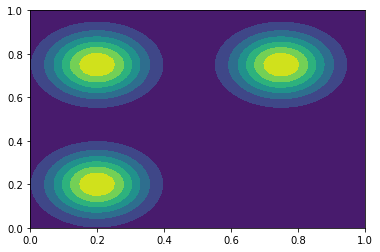

In [21]:
""" Probability Distribution """
def unnorm_p1(x): 
    return np.exp(-50.5 * np.sum((x[:2] - 0.2)**2)) \
                + np.exp(-50.5 * np.sum((x[:2] - 0.75)**2)) \
                + np.exp(-50.5 * np.sum((x[:2] - np.array([0.2, 0.75]))**2))
p1_total, _ = integrate.nquad(lambda *x: unnorm_p1(np.array(x)), [[0, 1], [0, 1]])
print("p1_total: ", p1_total)
p1 = lambda x: unnorm_p1(x)/p1_total

def unnorm_p2(x): 
    return np.exp(-50.5 * np.sum((x[:2] - 0.3)**2)) \
                + np.exp(-50.5 * np.sum((x[:2] - 0.65)**2)) \
                + np.exp(-50.5 * np.sum((x[:2] - np.array([0.3, 0.55]))**2))
p2_total, _ = integrate.nquad(lambda *x: unnorm_p2(np.array(x)), [[0, 1], [0, 1]])
print("p2_total: ", p2_total)
p2 = lambda x: unnorm_p2(x)/p2_total

# Grid and Display
X,Y = np.meshgrid(*[np.linspace(0,1)]*2)
_s = np.stack([X.ravel(), Y.ravel()]).T


plt.contourf(X, Y, np.array(list(map(p1, _s))).reshape(X.shape))      




In [24]:
""" Parameters """
x = [torch.tensor([0.54,0.3]), torch.tensor([0.2, 0.7]), torch.tensor([0.8, 0.1])]
U_shape=(1, 1)
n = len(U_shape)
mu_dist=p1
N=len(x)
delta_t=0.01
K=10
u_max=0.5
filename="mm_ergodic_dec_A=L0.15.mp4"
num_iter= 2000
O = torch.ones(3, 3) # A = 1 full communication
I = torch.diag(torch.ones(3)) # A = Id isolation
P = torch.tensor([[1, 1, 0], # A = P
              [1, 1, 0],
              [0, 0, 1]])

C = torch.tensor([[1, 1, 0], # A = C
              [1, 1, 1],
              [0, 1, 0]]) # some weird pairing
# Also A = Lr : communicates with things within radius r
A = I

fourier = {}
grad_fourier = {}
lambd = {}
mu = {}
for k in np.ndindex(*[K]*n):
    print(k)
    new_k = torch.tensor(k)*np.pi/torch.tensor(U_shape)
    fourier[k] = get_fourier_fn_k(new_k, U_shape)
    grad_fourier[k] = get_grad_fourier_fn_k(fourier[k])
    lambd[k] = get_lambda_k(new_k, n)
    mu[k] = get_mu_k(mu_dist, fourier[k], U_shape)

# index, position, total num, U_shape, umax, k_bands, eps=1e-5)
agents = [Agent(i, N, x[i], U_shape, u_max, list(np.ndindex(*[K]*n))) for i in range(N)]

(0, 0)
(0, 1)
(0, 2)
(0, 3)
(0, 4)
(0, 5)
(0, 6)
(0, 7)
(0, 8)
(0, 9)
(1, 0)
(1, 1)
(1, 2)
(1, 3)
(1, 4)
(1, 5)
(1, 6)
(1, 7)
(1, 8)
(1, 9)
(2, 0)
(2, 1)
(2, 2)
(2, 3)
(2, 4)
(2, 5)
(2, 6)
(2, 7)
(2, 8)
(2, 9)
(3, 0)
(3, 1)
(3, 2)
(3, 3)
(3, 4)
(3, 5)
(3, 6)
(3, 7)
(3, 8)
(3, 9)
(4, 0)
(4, 1)
(4, 2)
(4, 3)
(4, 4)
(4, 5)
(4, 6)
(4, 7)
(4, 8)
(4, 9)
(5, 0)
(5, 1)
(5, 2)
(5, 3)
(5, 4)
(5, 5)
(5, 6)
(5, 7)
(5, 8)
(5, 9)
(6, 0)
(6, 1)
(6, 2)
(6, 3)
(6, 4)
(6, 5)
(6, 6)
(6, 7)
(6, 8)
(6, 9)
(7, 0)
(7, 1)
(7, 2)
(7, 3)
(7, 4)
(7, 5)
(7, 6)
(7, 7)
(7, 8)
(7, 9)
(8, 0)
(8, 1)
(8, 2)
(8, 3)
(8, 4)
(8, 5)
(8, 6)
(8, 7)
(8, 8)
(8, 9)
(9, 0)
(9, 1)
(9, 2)
(9, 3)
(9, 4)
(9, 5)
(9, 6)
(9, 7)
(9, 8)
(9, 9)


In [43]:

agents = [Agent(i, N, x[i], U_shape, u_max, list(np.ndindex(*[K]*n))) for i in range(N)]
 


In [46]:
overall_e_log = []
for i in range(0, num_iter):
    t = i*delta_t # [time, time+time_step]

    """ Communication -- Local Broadcasting -- Uses Adjacency Matrix """
    # radius = 0.15
    # A = torch.zeros(N, N)
    # for j in range(0, N):
    #     for k in range(j, N):
    #         if torch.norm(agents[j].x_log[-1] - agents[k].x_log[-1]) < radius:
    #             if i%(num_iter//10) == 0:
    #                 print("Agent ", k, " and Agent ", j, "communication")
    #             A[k][j] = 1
    #             A[j][k] = 1
       

    """ Communication -- Adjacency Matrix A """
    sharec = {}

    A_neighbors = torch.matmul(A, torch.ones(N, 1))
    for k in np.ndindex(*[K]*n):
        # what to do if agent doesnt have k band
        c_k = torch.tensor([agents[j].c_k[k] for j in range(N)]).reshape(N, 1)
        # sharec[k] -> c_k as t -> infty

        sharec[k] = torch.matmul(A.double(), c_k) / A_neighbors.double()
 
    for j in range(N):
        agents[j].update_shared_c_k({k: sharec[k][j] for k in agents[j].k_bands})
        # agents[j].update_adj_neighbors(A_neighbors[j])

    """ Calculate overall ergodicity -- Not used in actual? """
    e = 0
    for k in np.ndindex(*[K]*n):
        ave_c_k = (1/N)*sum([agents[j].agent_c_k[k] for j in range(N)])
        e += lambd[k]*(ave_c_k-mu[k])**2
    overall_e_log.append(e)  
 
    """ Agent Moving """
    for j in range(N):    
        agents[j].apply_dynamics(t, delta_t)        



Agent  0  and Agent  0 communication
Agent  1  and Agent  1 communication
Agent  2  and Agent  2 communication
Agent:  0  had oh no at time  0.0
Agent:  1  had oh no at time  0.0
Agent:  2  had oh no at time  0.0
Agent  0  and Agent  0 communication
Agent  1  and Agent  1 communication
Agent  2  and Agent  2 communication
Agent  0  and Agent  0 communication
Agent  2  and Agent  0 communication
Agent  1  and Agent  1 communication
Agent  2  and Agent  2 communication
Agent:  0  had oh no at time  4.51
Agent:  0  had oh no at time  4.53
Agent:  0  had oh no at time  4.59
Agent:  0  had oh no at time  4.64
Agent  0  and Agent  0 communication
Agent  2  and Agent  0 communication
Agent  1  and Agent  1 communication
Agent  2  and Agent  1 communication
Agent  2  and Agent  2 communication
Agent  0  and Agent  0 communication
Agent  1  and Agent  0 communication
Agent  2  and Agent  0 communication
Agent  1  and Agent  1 communication
Agent  2  and Agent  1 communication
Agent  2  and Agen

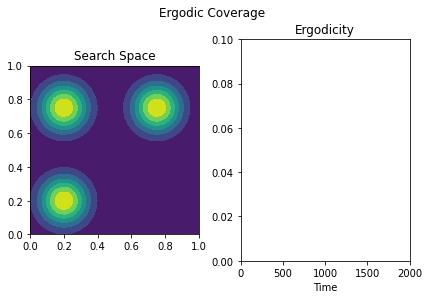

In [47]:
""" Animate """
colors = ['r', 'm', 'c', 'y', 'g', 'b', 'k', 'w']
if N > len(colors):
    raise NotYetImplemented("Number of agents: ", N, "- Animation of this dimension is not supported.")

fig, (ax1, ax2) = plt.subplots(1, 2)

fig.suptitle('Ergodic Coverage')
fig.tight_layout()


ax1.set_title('Search Space')
ax1.set_aspect('equal')
ax1.set_xlim(0, U_shape[0])
ax1.set_ylim(0, U_shape[1])

X,Y = np.meshgrid(np.linspace(0, U_shape[0]), np.linspace(0, U_shape[1]))
_s = np.stack([X.ravel(), Y.ravel()]).T
ax1.contourf(X, Y, np.array(list(map(mu_dist, _s))).reshape(X.shape))

ax2.set_title('Ergodicity')
ax2.set(xlabel='Time')

pos_data = [([], []) for i in range(N)]
time_data = []
ergodicity_data = []
local_ergodicity_data = [[] for i in range(N)]
pos_lns = []
local_erg_lns = []
for i in range(N):
    pos_ln, = ax1.plot(pos_data[i][0], pos_data[i][1], c=colors[i], label=i)
    pos_lns.append(pos_ln)

    local_erg, = ax2.plot(time_data, local_ergodicity_data[i], c=colors[i], label=i)
    local_erg_lns.append(local_erg)
ergodicity_ln, = ax2.plot(time_data, ergodicity_data, c='b')

def animate2d_init():
    phi2_max = 0.1 if num_iter is not None else max(overall_e_log)
    time_max = num_iter if num_iter is not None else min(1000, len(overall_e_log))
    ax2.set_xlim(0, time_max)
    ax2.set_ylim(0, phi2_max)
    return (ergodicity_ln, *local_erg_lns, *pos_lns)


def animate2d_from_logs_update(frame):
    time_data.append(frame)

    for i in range(N):
        pos_data[i][0].append(agents[i].x_log[frame][0])
        pos_data[i][1].append(agents[i].x_log[frame][1])
        pos_lns[i].set_data(pos_data[i][0], pos_data[i][1])

        local_ergodicity_data[i].append(agents[i].e_log[frame])
        local_erg_lns[i].set_data(time_data, local_ergodicity_data[i])
    
    ergodicity_data.append(overall_e_log[frame])
    ergodicity_ln.set_data(time_data, ergodicity_data)

    return (ergodicity_ln, *local_erg_lns, *pos_lns)



update = animate2d_from_logs_update
frames = len(overall_e_log)


FFwriter = animation.writers['ffmpeg']
writer = FFwriter(fps=30, metadata=dict(artist='Me'), bitrate=1800)
anime = animation.FuncAnimation(fig, animate2d_from_logs_update, init_func=animate2d_init, 
                            frames=frames, interval=20, blit=True)  
plt.show()
if filename is not None:
    anime.save(filename, writer=writer) 

In [20]:
# Spectral Decomposition
# K = 10
# Low 8 Mid 10 High 12
low = list(filter(lambda x: sum(x) < 8, np.ndindex(*[10]*2)))
high = list(filter(lambda x: sum(x) >= 8, np.ndindex(*[10]*2)))
print(len(low))
print(len(high))
f = mm_ergodic.functions
def create_band(band_k):
    return lambda x: sum([f[k]['mu_k']*f[k]['fourier_k'](torch.tensor(x)).numpy() for k in band_k])
low_band = create_band(low)
high_band = create_band(high)
recon_band = lambda x: low_band(x) + high_band(x)


fig, axes = plt.subplots(1, 4, figsize=(12+3, 3))
titles = ['Normal', 'Low', 'High', 'Reconstructed']
maps = [p1, low_band, high_band, recon_band]

fig.suptitle('Search Space')
fig.tight_layout()
levels = list(np.array(range(-4, 12))/2)
for i in range(len(axes)): 
    ax = axes[i]
    ax.set_title(titles[i])
    ax.set_aspect('equal')
    space = 1e-2
    ax.set_xlim(0-space, 1+space)
    ax.set_ylim(0-space, 1+space)
   
    X,Y = np.meshgrid(*[np.linspace(0,1)]*2)
    _s = np.stack([X.ravel(), Y.ravel()]).T

    
    q = ax.contourf(X, Y, np.array(list(map(maps[i], _s))).reshape(X.shape), levels=levels)  
    if levels is None:
        levels = q.levels
        print(levels)

plt.subplots_adjust(right=0.875)
cbar_ax = fig.add_axes([0.9, 0.05, 0.01, 0.8])
plt.colorbar(q, cax=cbar_ax)
plt.show()

36
64


NameError: name 'mm_ergodic' is not defined